In [1]:
import pandas as pd
from textblob import TextBlob
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/nicolepham-
[nltk_data]     nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nicolepham-
[nltk_data]     nguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# READ IN DATA (Choose data with profile field or without)
model_data_raw = pd.read_csv('fj.csv', index_col = 0)
#model_data_raw = pd.read_csv('fj_no_profile.csv')

# creating copy so original can still be accessed
model_data = model_data_raw.copy()

# droping unstructured columns
model_data.drop(['job_id','title','salary_range','description','requirements','benefits','posting'], axis = 1, inplace = True)

# one-hot encoding categorical variables
categorical_cols = ['location', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'company_profile'] 
model_data = pd.get_dummies(model_data, columns = categorical_cols)

# splitting data into train and test
X = model_data.drop('fraudulent', axis = 'columns')
y = model_data['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20,
                                                    random_state = 420)

In [3]:
indices = model_data_raw.groupby("company_profile").apply(lambda x: [i for i in x.index])
indices_tf = y[[i[0]for i in indices]]
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(indices, stratify = indices_tf, test_size=0.20, random_state = 422)
# Collapsing arrays
import numpy as np
train_idx = np.hstack(train_idx.apply(np.array).values)
test_idx = np.hstack(test_idx.apply(np.array).values)
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [4]:
#No Regularization

# defining pipeline entries
classifier = LogisticRegression(random_state = 420, max_iter=100, penalty = 'none')
smt = SMOTE(random_state=420)

# defining the pipeline
pipeline = Pipeline(steps = [['smote', smt],['classifier', classifier]])

In [6]:
# fitting the pipeline and printing results
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2976
           1       0.01      0.01      0.01        76

    accuracy                           0.95      3052
   macro avg       0.49      0.49      0.49      3052
weighted avg       0.95      0.95      0.95      3052



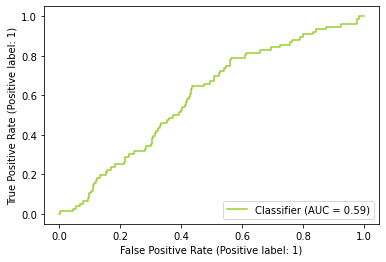

In [7]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba[:,1], color='yellowgreen')

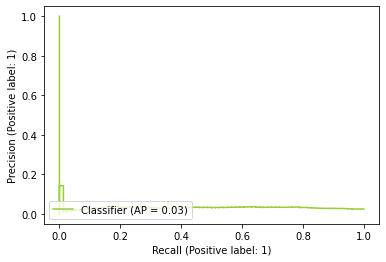

In [8]:
# Precision vs Recall Curve
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[:,1], color='yellowgreen')

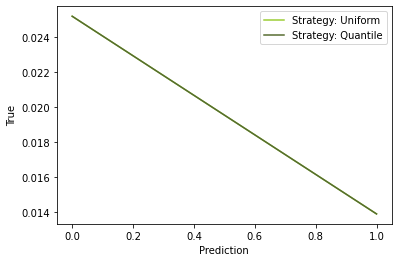

In [8]:
# Calibration Curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Strategy Uniform
prob_true1, prob_pred1 = calibration_curve(y_test, y_hat, strategy = 'uniform')

# Strategy Quantile
prob_true2, prob_pred2 = calibration_curve(y_test, y_hat, strategy = 'quantile')

plt.plot(prob_pred1, prob_true1, label='Strategy: Uniform', color='yellowgreen')
plt.plot(prob_pred2, prob_true2, label='Strategy: Quantile', color='darkolivegreen')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.legend(loc='best')
plt.show()